## Preprocessing & EDA

This part will primarily emphasize Exploratory Data Analysis (EDA) while also delving into feature engineering.

In [1]:
import pandas as pd
#import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

### Dataset

The dataset consists of two types of samples: those **embedded in paraffin and those after deparaffinization**. To **mitigate data leakage, we'll strictly utilize the training data**, specifically from the patient-level split dataset.

In [2]:
# import the datasets
train_PAR_patient = pd.read_csv('../data/train_PAR_patient.csv')
train_DEP_patient = pd.read_csv('../data/train_DEP_patient.csv')

## 1. Data exploration

The dataset contains the following columns:

In [3]:
train_PAR_patient.columns

Index(['Patient', 'Sample', 'Category', 'Lipids', 'Unsaturated lipids',
       'CH3 groups', 'CH2 groups', 'Ester groups',
       'Unsaturated/saturated lipid ratio', 'Lipid saturation',
       'Carbonyl/lipid ratio', 'Amide I', 'Lipid/protein ratio', 'Alpha helix',
       'Beta sheets', 'Beta turns', 'Alpha helix/beta sheets',
       'Percentage of beta forms', 'Band 1450', 'Band 1390', 'Band 1240',
       'Band 1080', 'Band 1310', 'Band 2850', 'Band 3060', 'Biomass_I',
       'Biomass_II', 'Biomass_Total'],
      dtype='object')

Besides the columns representing the origin and category of the samples, there are additional columns containing information about the intensity of IR peaks. Furthermore, some columns already show ratios of intensities. Let's have a look at the values in those columns.

In [4]:
train_PAR_patient.describe()

,Lipids,Unsaturated lipids,CH3 groups,CH2 groups,Ester groups,Unsaturated/saturated lipid ratio,Lipid saturation,Carbonyl/lipid ratio,Amide I,Lipid/protein ratio,...,Band 1450,Band 1390,Band 1240,Band 1080,Band 1310,Band 2850,Band 3060,Biomass_I,Biomass_II,Biomass_Total
count,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,...,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000
mean,35.508742,-0.016852,3.158983,16.054825,-0.173601,-0.008055,5.052958,-0.005236,5.714498,8.512385,...,1.398406,0.476344,0.393570,0.725667,0.026784,5.814356,0.087951,45.257090,34.000116,79.257206
std,11.679008,0.005528,1.079200,5.686676,0.070753,0.171228,1.373080,0.171264,2.513006,80.110904,...,0.433627,0.146936,0.161557,0.577079,0.025731,1.943406,0.057000,15.225508,12.553795,26.091457
min,-0.017618,-0.079906,-0.022677,0.000723,-0.559956,-20.574695,-12.500501,-9.467781,-0.479894,-3182.502180,...,-0.011090,-0.132053,-0.086068,-0.138383,-0.202773,0.001898,-0.175046,-8.158055,-14.782044,-17.840006
25%,31.452936,-0.019842,2.670191,14.204567,-0.220255,-0.006095,4.373478,-0.006580,3.987826,4.702424,...,1.182823,0.386485,0.289773,0.464356,0.016903,5.236549,0.053403,37.014049,26.879172,64.203101
50%,37.792600,-0.016926,3.264438,17.601679,-0.177021,-0.005166,5.284103,-0.004674,6.002522,6.288154,...,1.412089,0.489412,0.407112,0.602629,0.029730,6.203258,0.089605,48.251413,34.388698,82.318400
75%,43.326807,-0.013915,3.855224,19.960230,-0.126875,-0.004580,5.814490,-0.003594,7.386763,8.575766,...,1.646005,0.554875,0.504551,0.774763,0.041119,7.076611,0.117680,54.826830,41.365669,94.939465
max,85.482173,0.000388,12.273891,29.254765,0.332083,1.315750,100.891181,17.282730,18.016197,4662.804150,...,4.365792,1.673367,1.327351,5.472854,0.215199,11.516098,0.738455,131.239033,114.385624,237.947558


We've noticed a **significant number of negative values in the data**. Typically, negative values hold no physical significance, as concentrations cannot be negative. However, in this context, negative values indicate that the baseline in the spectrum exceeds the peak, which can occur when very few or no counts are observed. Despite this, negative values still provide valuable information about the spectrum's shape. Therefore, I will retain these variables for the time being.

### 1.A. Data distribution

Let's examine the distribution of peak intensities between the paraffin-embedded and deparaffinized samples for Biomass_Total, which accurately reflects the sample's composition, as well as another column exhibiting high counts.

In [5]:
# Identify column with high counts (excluding Biomass and columns which are ratios of peak areas)
# Selecting numeric columns that do not contain specified substrings in their names
numeric_columns = train_PAR_patient.select_dtypes(include='number').filter(regex='^(?!.*(?:ercentage|ratio|iomass)).*$')

# Calculating median values for each column
median_values = numeric_columns.median()

# Selecting three column names with the highest median values
top_3_columns = median_values.nlargest(3).index.tolist()

print("Columns with the highest median values:")
print(top_3_columns)

Columns with the highest median values:
['Lipids', 'CH2 groups', 'Band 2850']


In [6]:
# Create colour palette
palette = ["#58508d","#ff6361"]

<Axes: xlabel='Biomass_Total', ylabel='Count'>

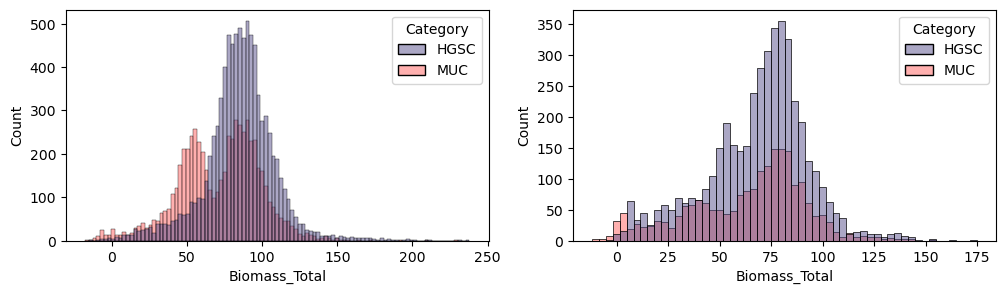

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
sns.histplot(train_PAR_patient, x='Biomass_Total', hue='Category', ax=ax1, palette = palette)
sns.histplot(train_DEP_patient, x='Biomass_Total', hue='Category', ax=ax2, palette = palette)

<Axes: xlabel='Band 2850', ylabel='Count'>

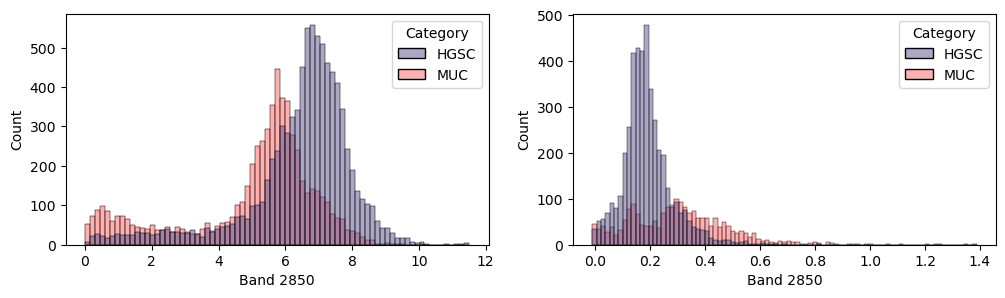

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
sns.histplot(train_PAR_patient, x='Band 2850', hue='Category', ax=ax1, palette = palette)
sns.histplot(train_DEP_patient, x='Band 2850', hue='Category', ax=ax2, palette = palette)

We observe that both paraffin-embedded and deparaffinized samples of both HGSC and MUC exhibit **multimodal distributions**. This could be attributed to improper or absent normalization of spectra. Variations in specimen thickness or density may lead to differences in counts under peaks among specimens. 

**To tackle this issue, we will compute ratios of these counts instead of using the counts directly. This approach will mitigate normalization concerns.**

### 1.B. Differences between HGSC and MUC

Before proceeding further, let's **assess whether there are statistically significant differences between HGSC and MUC samples**.

Given that the samples do **not follow normal distributions, we will employ the Mann-Whitney U test**, a non-parametric test that does not assume normality. However, when conducting multiple hypothesis tests simultaneously (in this case, across multiple columns between two datasets), we must address the heightened risk of false positives. To mitigate this, we will apply the **Bonferroni correction**, adjusting the significance level (the p-value threshold) by dividing it by the number of comparisons being made.

In [9]:
def compare_categories(dataset, alpha):
    """
    Compare numeric columns between HGSC and MUC samples in a dataset using Mann-Whitney U test with Bonferroni correction.
    
    Args:
    dataset: DataFrame, dataset containing numeric columns and 'Category' column
    alpha: float, significance level
    
    Returns:
    significant_difference: list of column names with significant difference
    no_significant_difference: list of column names with no significant difference
    """
    # Get the number of numeric columns
    num_columns = len(dataset.select_dtypes(include='number').columns)

    # Initialize empty lists to store column names
    significant_difference = []
    no_significant_difference = []

    # Iterate through each numeric column
    for column in dataset.select_dtypes(include='number'):
        # Extract the data for HGSC and MUC samples from the current numeric column
        data_hgsc = dataset[dataset['Category'] == 'HGSC'][column]
        data_muc = dataset[dataset['Category'] == 'MUC'][column]

        # Perform Mann-Whitney U test
        statistic, p_value = mannwhitneyu(data_hgsc, data_muc)

        # Apply Bonferroni correction
        p_value_corrected = p_value * num_columns

        # Check if the difference is significant after Bonferroni correction
        if p_value_corrected < alpha:
            significant_difference.append(column)
        else:
            no_significant_difference.append(column)

    return significant_difference, no_significant_difference

In [10]:
# Statistically significant changes for samples in paraffine
significant_difference, no_significant_difference = compare_categories(train_PAR_patient, 0.05)
print("\033[1mPARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction:\033[0m", significant_difference,'\n')
print("\033[1mDEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction:\033[0m", no_significant_difference)

PARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction: ['Lipids', 'Unsaturated lipids', 'CH3 groups', 'CH2 groups', 'Ester groups', 'Lipid saturation', 'Carbonyl/lipid ratio', 'Amide I', 'Lipid/protein ratio', 'Alpha helix', 'Beta sheets', 'Beta turns', 'Alpha helix/beta sheets', 'Percentage of beta forms', 'Band 1450', 'Band 1390', 'Band 1240', 'Band 1080', 'Band 1310', 'Band 2850', 'Band 3060', 'Biomass_I', 'Biomass_II', 'Biomass_Total'] 

DEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction: ['Unsaturated/saturated lipid ratio']


In [11]:
# Statistically significant changes for deparaffinized samples
significant_difference, no_significant_difference = compare_categories(train_DEP_patient, 0.05)
print("\033[1mPARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction:\033[0m", significant_difference,'\n')
print("\033[1mDEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction:\033[0m", no_significant_difference)

PARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction: ['Lipids', 'CH2 groups', 'Unsaturated/saturated lipid ratio', 'Lipid saturation', 'Carbonyl/lipid ratio', 'Amide I', 'Lipid/protein ratio', 'Alpha helix', 'Beta sheets', 'Beta turns', 'Percentage of beta forms', 'Band 1450', 'Band 1390', 'Band 1240', 'Band 1080', 'Band 1310', 'Band 2850', 'Band 3060', 'Biomass_II', 'Biomass_Total'] 

DEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction: ['Unsaturated lipids', 'CH3 groups', 'Ester groups', 'Alpha helix/beta sheets', 'Biomass_I']


We notice **statistically significant differences in most of the features**. However, we must exercise caution with **Bonferroni correction, as it can elevate the risk of Type II errors, especially when dealing with correlated data**.

To gain a deeper understanding of potential correlations within our dataset, let's create pairplot visualizations for variables with a substantial count.

In [12]:
selected_columns = train_PAR_patient[['Category','Lipids', 'CH3 groups', 'CH2 groups','Alpha helix', 'Beta sheets','Band 1390',
       'Band 1240']].copy()

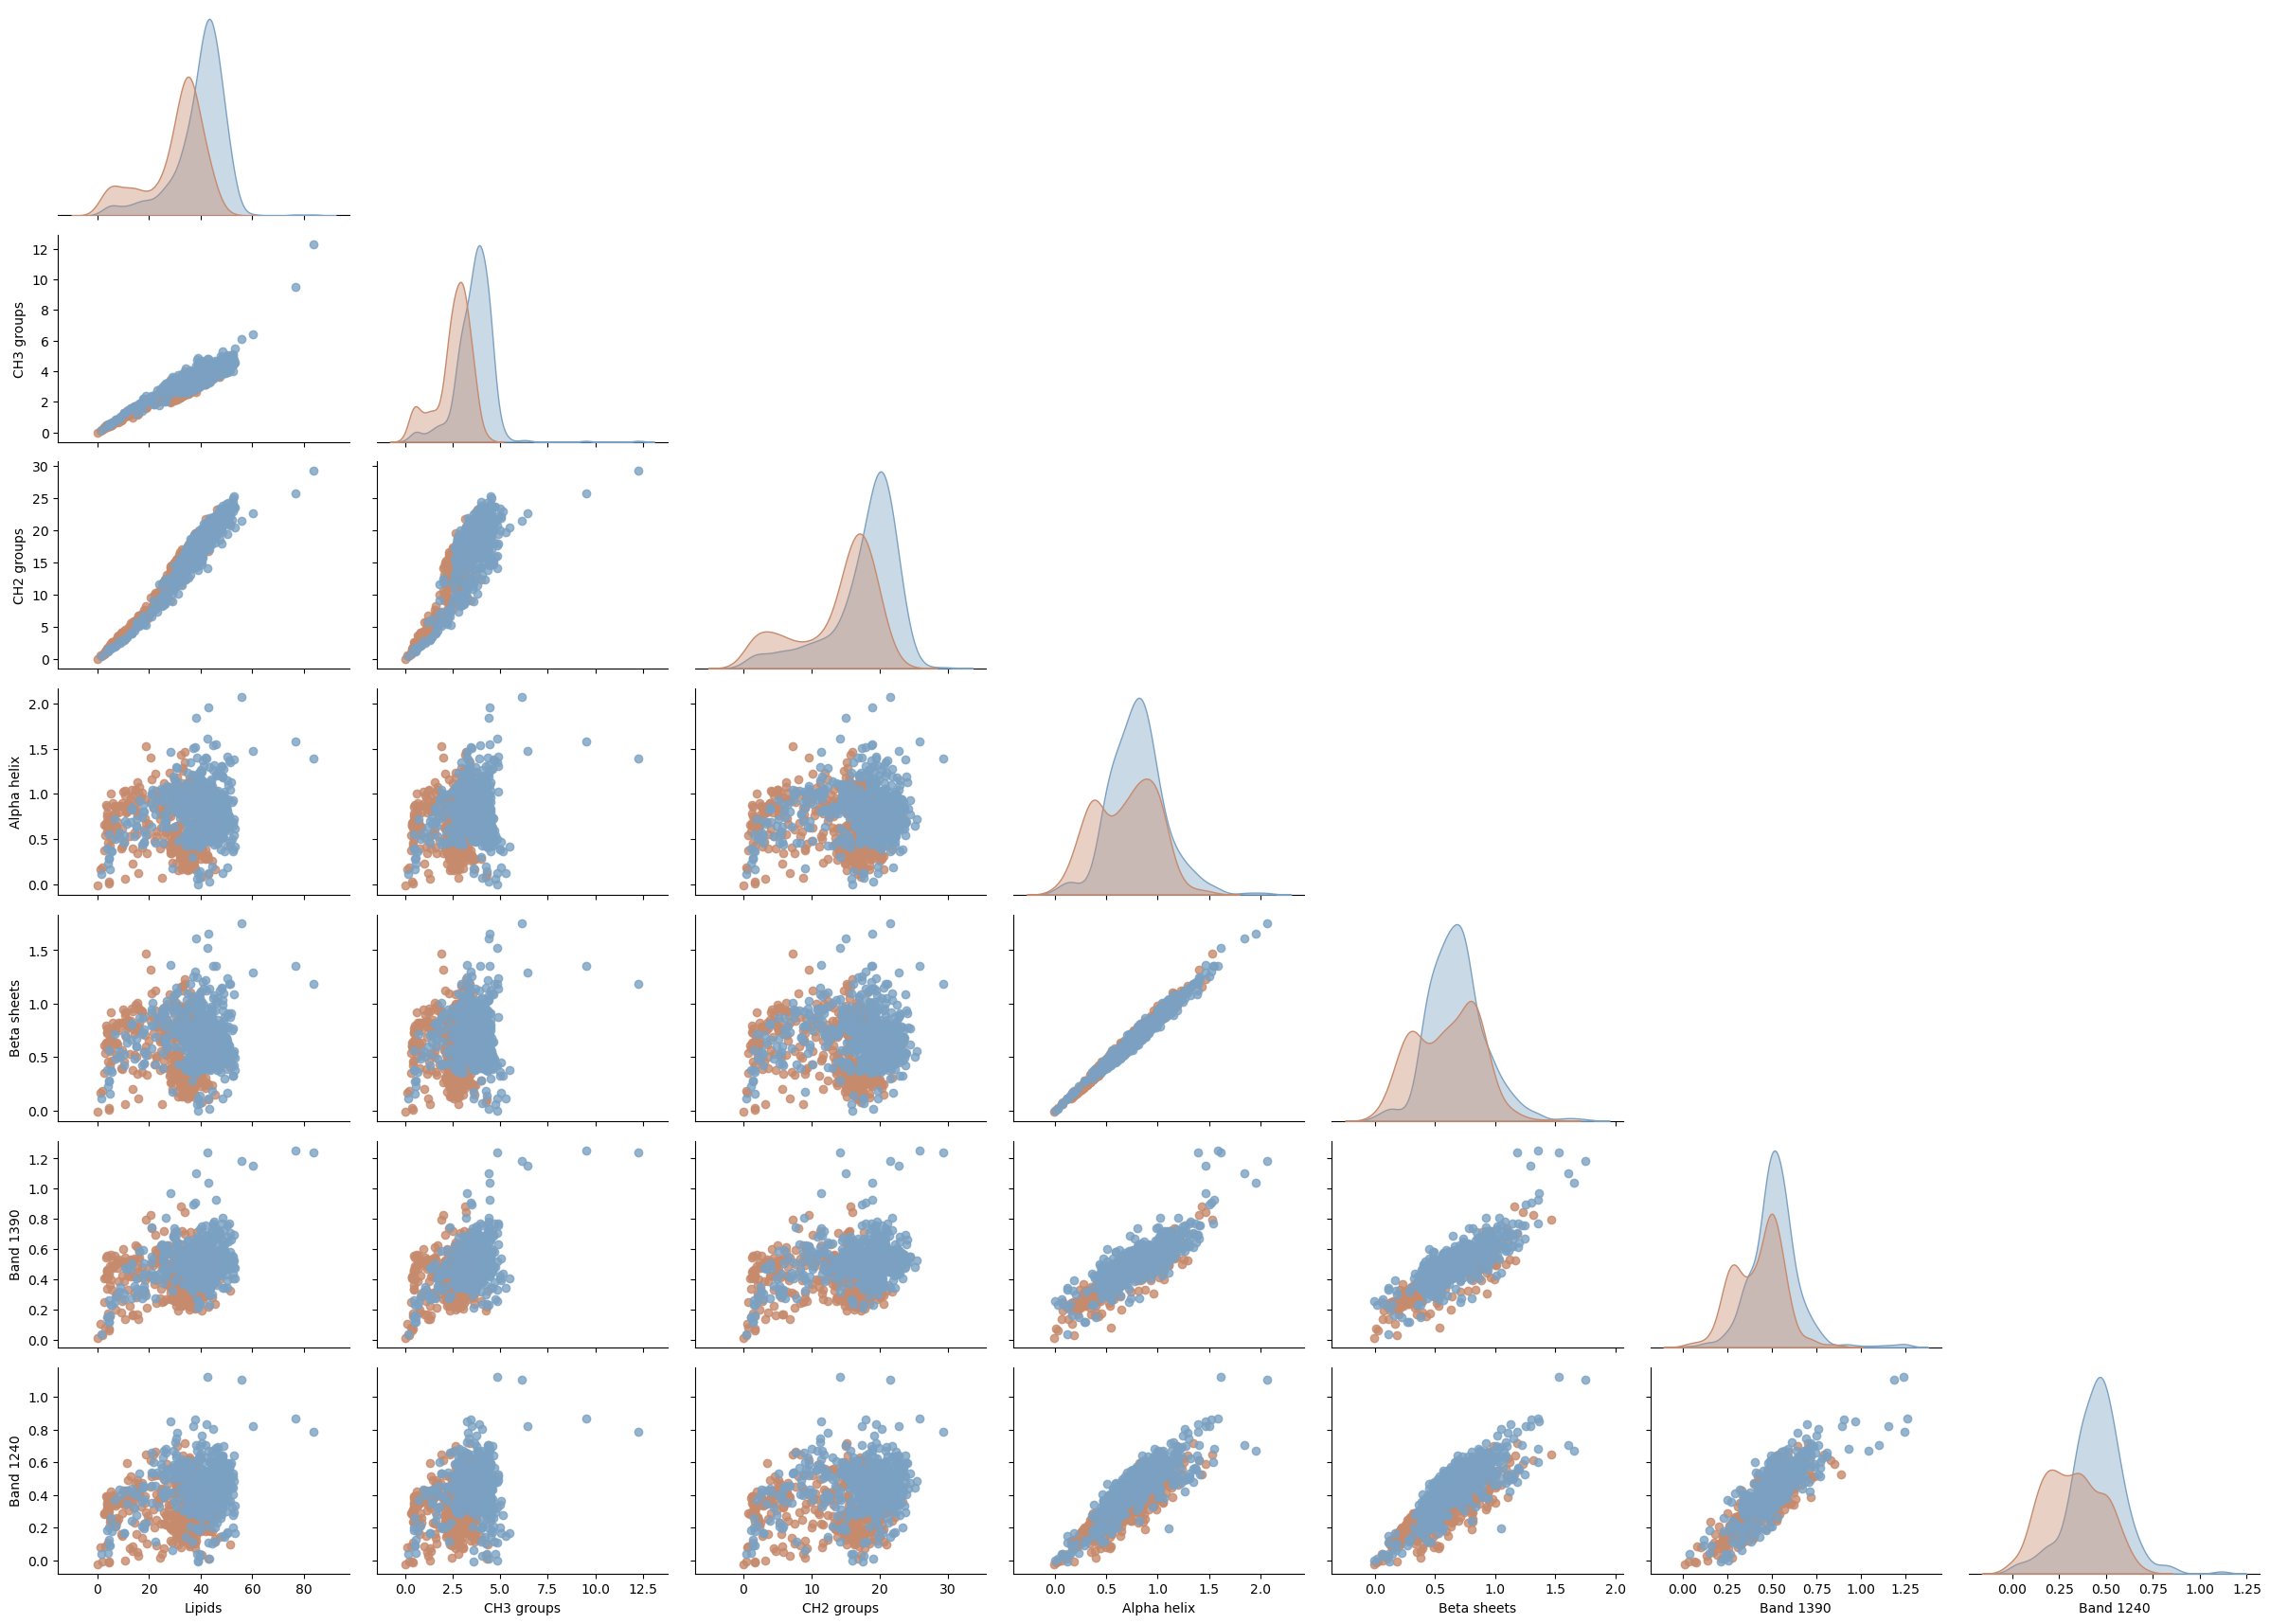

In [13]:
g = sns.PairGrid(selected_columns.sample(1000), hue='Category', palette = 'twilight_shifted_r', aspect=1.4, diag_sharey=False, corner=True)
g.map_lower(plt.scatter, alpha=0.8)
g.map_diag(sns.kdeplot, alpha=0.4, fill=True)

From the scatter plots displayed above, it's evident that numerous variables exhibit correlations. This underscores the importance of treating the results post Bonferroni correction with caution, given the heightened risk of Type II errors.

## 2. Ratios calculation

For reason mentioned before, the data exploration will be continued after the original data are replaced with selected ratios.  Only meaningful ratios were selected.

In [ ]:
def to_ratios(df):
    df['Biomass I/Biomass II'] = df['Biomass_I']/df['Biomass_II']
    df['Amide III/Amide I'] = df['Band 1310']/df['Amide I']
    df['1080/1240'] = df['Band 1080']/df['Band 1240']
    df['1450/1390'] = df['Band 1450']/df['Band 1390']
    df['1080/Amide I'] = df['Band 1080']/df['Amide I']
    df['10240/Amide I'] = df['Band 1240']/df['Amide I']
    df['(1450+1390)/Lipids'] = (df['Band 1450']+df['Band 1390'])/df['Lipids']
    df['1450/Lipids'] = df['Band 1450']/df['Lipids']
    df['1390/Lipids'] = df['Band 1390']/df['Lipids']
    df['Amide B/Amide I'] = df['Band 3060']/df['Amide I']
    df['Amide III/Amide B'] = df['Band 1310']/df['Band 3060']
    df['CH3/1450'] = df['CH3 groups']/df['Band 1450']
    df['2850/1450'] = df['Band 2850']/df['Band 1450']
    df.drop(['Lipids', 'Unsaturated lipids', 'CH3 groups', 'CH2 groups', 'Ester groups', 'Amide I','Alpha helix', 'Beta sheets', 'Beta turns',  'Band 1450', 'Band 1390', 'Band 1240', 'Band 1080', 'Band 1310', 'Band 2850', 'Band 3060', 'Biomass_I', 'Biomass_II', 'Biomass_Total'], axis=1, inplace=True)
    return df

In [ ]:
ratios_raw = to_ratios(data_raw.copy())
ratios_raw.info()

Again, let's split the data into separate datasets for samples in paraffine and deparaffinized. We need to do that before outliers removal because datasets may have different range for some variables

In [ ]:
ratios_raw_DEP = ratios_raw[data_raw.Category.str.contains('dep')]
ratios_raw_PAR = ratios_raw[data_raw.Category.str.contains('par')]

Above it can be seen that conversion to ratios did not cause any problems (eg. due to dividing by 0 or by very small values)

In [ ]:
ratios_raw_PAR.describe()

In [ ]:
ratios_raw_DEP.describe()

To detect outliers IQR (interquartile range) rule was applied. The outliers were not removed because having 19 variables, each having outliers, could lead to deleting a significant portion of the data. I chose to winsorize the outliers. This approach was selected because it's very unlikely that the data would be erroneous (there is no human factor because the spectra were fitted with well established algorithm and problems with background removal would very likely affect the whole spectrum) so for this reason I would rather believe that the ratios are truly very big or very small and thus the approach which would keep partly this information is to Winsorize them to the closest inlier.

In [ ]:
def outliers_lim(df, n=1.5):
    """
    finds limits for inliners with IQR method. 
    you can set the scaling factor n to some other value, e.g. 2 or 3
    """
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - n * IQR
    upper_lim = Q3 + n * IQR
    return lower_lim, upper_lim

In [ ]:
import scipy.stats as stats

def winsorize_outliers(df, limits):
    """
    winsorizes the given dataset.
    takes lower and upper limit as a tuple (lower, upper)
    """
    low, upp = limits
    cols = df.select_dtypes(include=np.number).columns.tolist()
    for col in cols:
        # find which percentile are the limits obtained with IQR...
        percentile_low = percentileofscore(df[col], low[col])/100
        percentile_upp = 1 - percentileofscore(df[col], upp[col])/100
        # ...and winsorize the data accordingly
        df[col] = stats.mstats.winsorize(df[col], limits = [percentile_low, percentile_upp])
    return df

### Data exploration 

#### of ratios of values in selected columns

In [ ]:
ratios_win_PAR = winsorize_outliers(ratios_raw_PAR.select_dtypes(include='number').copy(), outliers_lim(ratios_raw_PAR.select_dtypes(include='number')))
ratios_win_PAR.describe()

In [ ]:
ratios_win_DEP = winsorize_outliers(ratios_raw_DEP.select_dtypes(include='number').copy(), outliers_lim(ratios_raw_DEP.select_dtypes(include='number')))
ratios_win_DEP.describe()

Let's look at the distribution of values for both embedded in paraffine and deparaffinized samples.

In [ ]:
ratios_raw.columns

In [ ]:
n=0
for col in ratios_raw.select_dtypes(include=[np.number]):
    print(col)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    sns.histplot(ratios_win_PAR, x=col, hue='Category', ax=ax1, palette = 'Dark2')
    sns.histplot(ratios_win_DEP, x=col, hue='Category', ax=ax2, palette = 'Dark2')
    plt.show()

    

From the histograms above we can see, that Lipid saturation is a promising discriminant between HGSC and MUC in deparaffinized samples. For the samples in paraffine 1080/1240 cm^-1, 1240/Amide I and CH3/1450 bands seems to separate the samples quite well. Amide III/Amide B ratio looks promising for both types of samples.

Looking at boxplots will help us understand better the differences between the samples embedded in paraffin and the deparaffinized samples.

In [ ]:
df = pd.concat([ratios_win_PAR, ratios_win_DEP], axis=0)

In [ ]:
sns.boxplot(data=df, x='Lipid/protein ratio', y='Category', palette = 'deep')

It can be noted that deparaffinization influenced lipid saturation significantly. It may be caused by washing out of lipids by the solvent used.

In [ ]:
sns.boxplot(data=df, x='Lipid saturation', y='Category', palette = 'deep')

Especially we can see a change in the saturation of lipids (CH2 vibrational band / CH3 vibrational band) which may suggest more efficient washing out of CH2 groups.

In [ ]:
sns.boxplot(data=df, x='Amide III/Amide I', y='Category', palette = 'deep')

We can also observe that the ratio between Amide III and Amide I did not lower significantly after deparaffinization, and the trends observed for the samples in paraffine are maintained.

Now the data is ready for model building

#### Export data

Now the data is ready for the next step: model building

In [ ]:
ratios_win_PAR.to_csv('data/ratios_PAR.csv')
ratios_win_DEP.to_csv('data/ratios_DEP.csv')